# Matching SkyPy Sersic Profiles to Real Galaxy images

This notebook uses the match_simulated_to_real() function to generate an Astropy table that matches a simulated SkyPy source to a real galaxy from the COSMOS_23.5_catalog, using a . The resulting Astropy table can be queried for the FITS filename and HDU to load and display the resulting matched image.

In [1]:
import sys
import os
import pickle
from scipy.special import gamma
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table, hstack, Column, join
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck13, FlatLambdaCDM
from paltas.Sources.cosmos import COSMOSExcludeCatalog, COSMOSCatalog


from slsim.Pipelines import SkyPyPipeline
from slsim.Sources.galaxies import Galaxies
from slsim.Util.cosmo_util import match_simulated_to_real
from slsim.Sources.galaxies import galaxy_projected_eccentricity

In [11]:
# Define cosmology and sky area
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
sky_area = 1.5 * u.deg**2

# Paths to raw COSMOS data (replace with your local paths)
catalog1_path   = r"C:\Users\rahul\OneDrive\Documents\GitHub\Simulating_and_Predicting_Nancy_G_Roman_Telescope_Data\Datasets\COSMOS_23.5_Image_catalog\COSMOS_23.5_training_sample\real_galaxy_catalog_23.5.fits"
catalog2_path   = r"C:\Users\rahul\OneDrive\Documents\GitHub\Simulating_and_Predicting_Nancy_G_Roman_Telescope_Data\Datasets\COSMOS_23.5_Image_catalog\COSMOS_23.5_training_sample\real_galaxy_catalog_23.5_fits.fits"
morphology_path = r"C:\Users\rahul\OneDrive\Documents\GitHub\Simulating_and_Predicting_Nancy_G_Roman_Telescope_Data\Datasets\Morphology\cosmos_morphology_cassata_1.1.tbl"


def merge_catalogs(large_cat, small_cat,
                   lc_mag_col, sc_mag_col,
                   tolerance=1.0,
                   lc_ra_col='RA', lc_dec_col='DEC',
                   sc_ra_col='RA', sc_dec_col='DEC'):
    # SkyCoord objects
    Lcoords = SkyCoord(ra=large_cat[lc_ra_col], dec=large_cat[lc_dec_col])
    Scoords = SkyCoord(ra=small_cat[sc_ra_col], dec=small_cat[sc_dec_col])
    # match
    idx, d2d, _ = Scoords.match_to_catalog_sky(Lcoords)
    d2d_arcsec = d2d.to(u.arcsec)
    # mask by tolerance
    mask = d2d_arcsec < tolerance * u.arcsec
    # compute MAG_DIFF on matched
    small_cat['MAG_DIFF'] = np.nan
    small_cat['MAG_DIFF'][mask] = (small_cat[sc_mag_col][mask]
                                   - large_cat[lc_mag_col][idx][mask])
    # stack matched rows
    return hstack([large_cat[idx[mask]], small_cat[mask]])

# Cell 3 — Load and Merge Raw COSMOS Catalogs
cat1 = Table.read(catalog1_path, format='fits', hdu=1)
cat1['RA']  = cat1['RA']  * u.deg
cat1['DEC'] = cat1['DEC'] * u.deg

cat2 = Table.read(catalog2_path, format='fits', hdu=1)

catalog_merged = join(cat1, cat2,keys='IDENT')

# load morphology table
Morph_catalog = Table.read(morphology_path, format='ascii')

# merge by sky-coordinates and magnitude
Final_catalog = merge_catalogs(
    catalog_merged, Morph_catalog,
    lc_mag_col='MAG', sc_mag_col='MAG_AUTO_ACS',
    tolerance=1.0
)
print(f"Final_catalog after spatial merge: {len(Final_catalog)} rows")

# Cell 4 — Compute Real Radii & Absolute Magnitude
ang_dist = cosmo.angular_diameter_distance(Final_catalog['zphot'])
Final_catalog['R_PETRO_real'] = (Final_catalog['R_PETRO']
    * Final_catalog['PIXEL_SCALE']
    * ang_dist
    * 4.84814e-6)
Final_catalog['R_HALF_real'] = (Final_catalog['R_HALF']
    * Final_catalog['PIXEL_SCALE']
    * ang_dist
    * 4.84814e-6)
Final_catalog['MAG_abs'] = (Final_catalog['MAG']
    + 5
    - 5*np.log10(ang_dist.value * 1e6)
)

phi_deg = np.vstack(Final_catalog['sersicfit'])[:, 5]   # shape (N,)
Final_catalog['phi_G'] = np.deg2rad(phi_deg)



# Cell 5 — Rename and Clean Columns
column_mapping = {
    'RA_1':          'RA',
    'DEC_1':         'DEC',
    'R_PETRO':       'RPETRO',
    'R_HALF':        'RHALF',
    'CONC_PETRO':    'CONCPETRO',
    'R_PETRO_real':  'RPETROreal',
    'R_HALF_real':   'RHALFreal',
    'MAG_abs':       'MAGabs'
}
for old, new in column_mapping.items():
    if old in Final_catalog.colnames:
        Final_catalog.rename_column(old, new)

# drop extraneous
for col in ['RA_2','DEC_2','NOISE_MEAN','MAG_AUTO_ACS',
            'fit_status','fit_mad_s','fit_mad_b','fit_dvc_btt',
            'use_bulgefit','hlr']:
    if col in Final_catalog.colnames:
        Final_catalog.remove_column(col)


print(f"Cleaned Final_catalog: {len(Final_catalog)} rows")

source_params_dict = {'z_source' : 1.5,
'cosmos_folder' : r"C:\Users\rahul\OneDrive\Documents\GitHub\Simulating_and_Predicting_Nancy_G_Roman_Telescope_Data\Datasets\COSMOS_23.5_Image_catalog\COSMOS_23.5_training_sample",
'max_z' : 1.0,
'minimum_size_in_pixels' : 50,
'faintest_apparent_mag' : 20,
'smoothing_sigma' : 0.0,
'random_rotation' : True,
'output_ab_zeropoint' : 25.127,
'center_x' : 0.0,
'center_y' : 0.0,
'min_flux_radius' : 10.0,
'source_exclusion_list' : [79, 309, 1512, 5515, 7138, 7546, 9679, 14180, 14914, 19494, 22095, 28335, 32696, 32778, 33527, 34946, 36344, 38328, 40837, 41255, 44363, 44871, 49652, 51303, 52021, 55803, 1368, 1372, 1626, 5859, 6161, 6986, 7312, 8108, 8405, 9349, 9326, 9349, 9745, 9854, 9948, 10146, 10446, 11209, 12397, 14642, 14909, 15473, 17775, 17904, 20256, 20489, 21597, 21693, 22380, 23054, 23390, 23790, 24110, 24966, 26135, 27222, 27781, 28297, 29550, 30089, 30898, 30920, 31548, 32025, 33699, 35553, 36409, 36268, 36576, 37198, 37969, 38873, 40286, 40286, 40924, 41731, 44045, 45066, 45929, 45929, 46575, 47517, 48137, 49441, 52270, 52730, 52759, 52891, 54924, 54445, 55153, 10584, 22051, 22365, 23951, 42334, 42582, 51492, 32135, 37106, 37593, 38328, 45618, 47829]
}


# Create an instance of the COSMOSCatalog class
cosmos_exclude_catalog = COSMOSExcludeCatalog(cosmo, source_params_dict)

catalog_data_with_cuts = cosmos_exclude_catalog._passes_cuts()

filtered_catalog = cat1[catalog_data_with_cuts]
ident_numbers = filtered_catalog['IDENT'].data
ident_array = np.array(ident_numbers)

Final_catalog_with_cuts = Final_catalog[np.isin(Final_catalog['IDENT'], ident_array)]
Final_catalog_with_cuts

Final_catalog after spatial merge: 56882 rows
Cleaned Final_catalog: 56882 rows


IDENT,RA,DEC,MAG,BAND,WEIGHT,GAL_FILENAME,PSF_FILENAME,GAL_HDU,PSF_HDU,PIXEL_SCALE,NOISE_VARIANCE,NOISE_FILENAME,stamp_flux,mag_auto,flux_radius,zphot,sersicfit,bulgefit,viable_sersic,flux,ID,RPETRO,RHALF,CONCPETRO,ASYMMETRY,GINI,M20,Axial Ratio,AUTOCLASS,CLASSWEIGHT,MAG_DIFF,RPETROreal,RHALFreal,MAGabs,phi_G
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,Mpc,,
int32,float64,float64,float64,bytes5,float64,bytes32,bytes36,int32,int32,float64,float64,bytes26,float64,float64,float64,float64,float64[8],float64[16],int32,float64[4],int32,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64
59,149.48443,2.499059,18.253999710083008,F814W,0.23535999655723572,real_galaxy_images_23.5_n50.fits,real_galaxy_PSF_images_23.5_n50.fits,495,495,0.029999999329447746,6.852480055385968e-06,acs_I_unrot_sci_20_cf.fits,1342.2126123344424,18.253751754760742,18.63823699951172,0.09070000052452087,0.19420617661205308 .. 1.8847319101190698,0.09475306318440165 .. -1.2609097185039793,1,1370.1729704081495 .. 1377.3380435753097,59,41.7070007,16.6669998,3.71,0.01,0.551,-2.2,0.591,1,0.91,-0.02459911008300608,0.0021155172372420744,0.0008454054422093748,-19.458556347531207,3.1278095478963133
93,149.478408,2.493552,18.606000900268555,F814W,0.28029999136924744,real_galaxy_images_23.5_n44.fits,real_galaxy_PSF_images_23.5_n44.fits,660,660,0.029999999329447746,6.150969966256525e-06,acs_I_unrot_sci_20_cf.fits,949.0878687689506,18.60556983947754,45.560428619384766,0.09200000017881393,0.028637101507350854 .. 1.8700042414013516,0.02945084552670157 .. 2.3785512454660145,1,921.091052317406 .. 0.0,94,113.6880035,45.4580002,3.4319999,0.077,0.553,-1.962,0.646,2,0.55,-0.02880100026855459,0.00584051853886066,0.002335323734554206,-19.13420094719227,6.709497070277964
153,149.463639,2.458857,19.851999282836914,F814W,0.24009999632835388,real_galaxy_images_23.5_n18.fits,real_galaxy_PSF_images_23.5_n18.fits,445,445,0.029999999329447746,7.81205017119646e-06,acs_I_unrot_sci_20_cf.fits,284.6577662890322,19.85228157043457,30.20516586303711,0.484499990940094,0.021973440678794823 .. -0.35144456630356,0.02019261742544862 .. 0.4150135647497668,1,299.877308289731 .. 0.0,156,56.8790016,28.0020008,2.9949999,0.115,0.432,-1.86,0.724,2,0.82,-0.027898782836913938,0.010240816995215672,0.005041638524342221,-20.61143193323992,4.652052919848466
163,149.465751,2.485496,17.33300018310547,F814W,0.2559199929237366,real_galaxy_images_23.5_n3.fits,real_galaxy_PSF_images_23.5_n3.fits,738,738,0.029999999329447746,7.703430128458422e-06,acs_I_unrot_sci_20_cf.fits,3043.1149513577193,17.332963943481445,39.825523376464844,0.09200000017881393,0.08823207124812635 .. -0.72155421844072,0.05628887233047251 .. 2.4235220527061503,1,3192.4945661636657 .. 0.0,166,103.8099976,39.9210014,3.697,0.016,0.567,-2.1559999,0.722,1,0.91,-0.024200483105467185,0.00533305359260602,0.002050870290519108,-20.407201664355355,5.917116587376952
231,149.451387,2.466789,19.750999450683594,F814W,0.2331399917602539,real_galaxy_images_23.5_n30.fits,real_galaxy_PSF_images_23.5_n30.fits,541,541,0.029999999329447746,6.963390205783071e-06,acs_I_unrot_sci_20_cf.fits,348.83529064356026,19.7513484954834,14.753897666931152,0.47049999237060547,0.04913574850343814 .. 1.009121383910505,0.006967147355717804 .. 1.0469746532332687,1,374.5424862408457 .. 0.0,235,38.7750015,14.4350004,3.974,0.02,0.584,-2.227,0.819,1,0.91,-0.024099350683592036,0.006869667898704907,0.002557412121974321,-20.67743815744828,2.6545467353431658
247,149.448402,2.463337,18.128000259399414,F814W,0.2985599935054779,real_galaxy_images_23.5_n18.fits,real_galaxy_PSF_images_23.5_n18.fits,941,941,0.029999999329447746,6.74601005812292e-06,acs_I_unrot_sci_20_cf.fits,1393.7019878421447,18.128217697143555,48.16819381713867,0.2305999994277954,0.04561641222036482 .. 0.6506048302488516,0.043618297225518625 .. 0.6832276854018128,1,1371.3648209867238 .. 0.0,252,101.8460007,46.8310013,2.964,0.208,0.469,-1.5549999,0.833,2,0.64,-0.024200459399413177,0.01124

In [19]:
# Cell 7 — Build the Simulated SkyPy Catalog
pipeline = SkyPyPipeline(
    skypy_config=None,
    sky_area=sky_area,
    filters=None,
    cosmo=cosmo,
)
galaxy_list = pipeline.blue_galaxies
kwargs_cut = {
    'band':     'i',
    "band_max": 20,
    'z_min':    0.1,
    'z_max':    1.5,
}
source_simulation = Galaxies(
    galaxy_list=galaxy_list,
    kwargs_cut=kwargs_cut,
    cosmo=cosmo,
    sky_area=sky_area,
    catalog_type='skypy',
    source_size=None
)

""""
def compute_sersic_radius(row):
    #Compute the refined Sérsic radius R_e for a given galaxy row.
    physical_size = row['physical_size']  # Size in kpc
    n_sersic = row['n_sersic']  # Sérsic index
    M = row['M']  # Absolute magnitude
    ellipticity = row['ellipticity']  # Ellipticity factor

    # Empirical size-luminosity relation based on Shen et al. (2003) and Bernardi et al. (2014)
    if n_sersic < 2.5:
        # Late-type (spirals & disks)
        log_R_e = -0.25 * M - 1.84
    else:
        # Early-type (ellipticals)
        log_R_e = -0.4 * M - 5.06

    R_e = 10**log_R_e  # Convert log scale to kpc

    # Refine using ellipticity correction (approximate adjustment)
    R_e *= np.sqrt(1 - ellipticity)

    # Ensure R_e is within reasonable limits
    R_e = max(R_e, 0.1)  # Prevents unphysical values
    return R_e

"""

sim_table = source_simulation._galaxy_select
sim_table

z,M,coeff,ellipticity,physical_size,stellar_mass,angular_size,mag_g,mag_r,mag_i,mag_z,mag_y,e1,e2,n_sersic
,,,,kpc,,arcsec,,,,,,,,
float64,float64,float64[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.33105175337194437,-20.929236098652655,0.12758272510331437 .. 0.04819756396241365,0.5399857413543396,8.204828158838916,76030297215.87766,1.7228773051313186,20.665559705666315,19.809693873165973,19.445950725808093,19.21549019508817,19.07010919840214,-1.0,-1.0,-1.0
0.24681658646068952,-20.075021841151155,0.2360641708046164 .. 0.06653177897843073,0.20805615892543775,5.0589703619837,16812214090.094131,1.306122395805483,20.53386619191344,19.967269257312225,19.71880708684685,19.5490514873812,19.478193516770453,-1.0,-1.0,-1.0
0.43158126837914107,-21.290693121649355,0.04314813382702961 .. 0.04760024271335891,0.8098796210250401,3.6552231547896454,45166675738.40936,0.6501458328123599,20.887246525802585,20.221596949235337,19.988653103410346,19.876617488861402,19.62625234612064,-1.0,-1.0,-1.0
0.2118702919132631,-19.810183743056065,0.21667069409015927 .. 0.18134962888385298,0.37931676362656497,6.155463271762338,5630439186.371463,1.7836735821087348,20.389603562574354,19.889467707497904,19.623860157512016,19.61589670379762,19.553354445393968,-1.0,-1.0,-1.0
0.5921402751698569,-22.323339254823527,0.05312312196133595 .. 0.01494996949371459,0.4599272912769181,8.74865711481129,289622160118.1823,1.3166730578799395,21.45464949459949,20.38619589265114,19.647334055943812,19.398767697145086,19.187610756998662,-1.0,-1.0,-1.0
0.18351512999427844,-20.95518354558692,0.11374424231453346 .. 0.05647909519965269,0.5521002973102346,9.410581029155477,52562994167.41882,3.052945926892764,18.87039235901813,18.293692317147343,17.978668114890343,17.86357962351011,17.75094719016491,-1.0,-1.0,-1.0
0.29236225318696524,-20.723184726761815,0.4519969037844217 .. 0.12346939949377003,0.2982451592040315,3.3400034265555716,24633820658.319965,0.7634032904236805,20.24633607803654,19.78649554229229,19.618549465405298,19.392374018375495,19.351063475895398,-1.0,-1.0,-1.0
0.1522475915068464,-20.425759079726166,0.11826093797646588 .. 0.03710066128620887,0.6883649586784035,6.070081165196912,29220938585.944576,2.293232582514243,18.891565250967965,18.38519109316612,18.07375513451474,17.991242291830176,17.8861088264307,-1.0,-1.0,-1.0


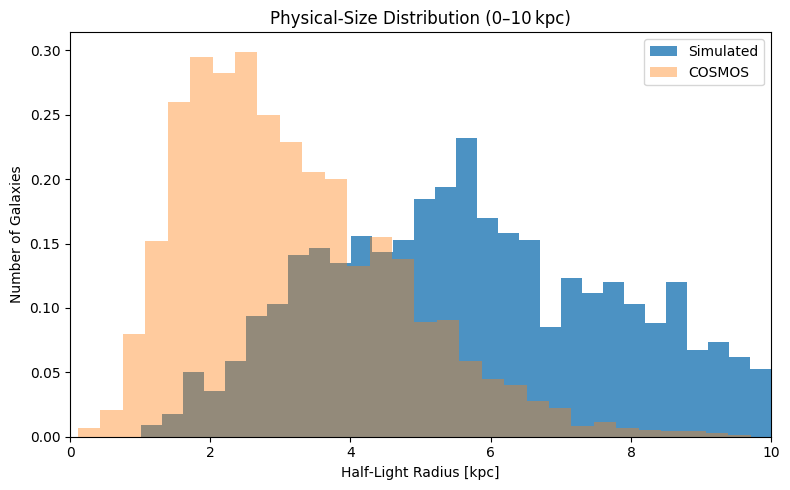

In [20]:
# Extract and convert to kpc
sim_sizes_kpc    = np.array(sim_table['physical_size'])
cosmos_sizes_kpc = np.array(Final_catalog_with_cuts['RHALFreal']) * 1000.0

# Mask out outliers (0–10 kpc)
mask_sim  = (sim_sizes_kpc  >= 0) & (sim_sizes_kpc  <= 10)
mask_cos  = (cosmos_sizes_kpc >= 0) & (cosmos_sizes_kpc <= 10)

# Plot overlaid histograms with different transparencies for contrast
plt.figure(figsize=(8, 5))
plt.hist(sim_sizes_kpc[mask_sim],   bins=30, alpha=0.8, label='Simulated', color='C0', density=True)
plt.hist(cosmos_sizes_kpc[mask_cos], bins=30, alpha=0.4, label='COSMOS',   color='C1', density=True)
plt.xlim(0, 10)
plt.xlabel('Half‐Light Radius [kpc]')
plt.ylabel('Number of Galaxies')
plt.title('Physical‐Size Distribution (0–10 kpc)')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Cell 8 — Add Unique ID to Simulated Table
sim_table['IDENT'] = np.arange(len(sim_table))

# Cell 9 — Perform Nearest-Neighbor Matching
matched = match_simulated_to_real(
    sim_table       = sim_table,
    cosmos_catalog  = Final_catalog_with_cuts,
    cosmo           = cosmo,
    tolerance       = 0.008,
    mag_col_sim     = 'mag_i',
    size_col_sim    = 'physical_size',
    mag_col_cat     = 'MAGabs',
    size_col_cat    = 'RHALFreal',
    id_col_sim      = 'IDENT',
    id_col_cat      = 'ID',
)
print(f"Total matches kept: {len(matched)} rows")


for entry in matched:
    e1, e2 = galaxy_projected_eccentricity(
    float(entry['ellipticity']), rotation_angle=entry['COSMOS_phi_G']
    )
    entry['e1'] = e1
    entry['e2'] = e2


# Save the matched table as a pickle file
pickle_file_path = r"C:\Users\rahul\OneDrive\Documents\GitHub\slsim-COSMOS-source-class\notebooks\matched_table.pkl"
with open(pickle_file_path, 'wb') as f:
    pickle.dump(matched, f)

print(f"Matched table saved to {pickle_file_path}")

# To load the pickle file in another notebook
# with open(pickle_file_path, 'rb') as f:
#     loaded_matched = pickle.load(f)
# print("Matched table loaded successfully")

Total matches kept: 711 rows
Matched table saved to C:\Users\rahul\OneDrive\Documents\GitHub\slsim-COSMOS-source-class\notebooks\matched_table.pkl


In [ ]:

import matplotlib.pyplot as plt
from lenstronomy.LightModel.light_model import LightModel

# Directory where your COSMOS FITS images live
real_images_dir = r"C:\Users\rahul\OneDrive\Documents\GitHub\Simulating_and_Predicting_Nancy_G_Roman_Telescope_Data\Datasets\COSMOS_23.5_Image_catalog\COSMOS_23.5_training_sample"

# Instantiate a Lenstronomy Sersic‐ellipse model
lightModel = LightModel(light_model_list=['SERSIC_ELLIPSE'])

# Sort the matched table by Distance and take the best 20
top20 = matched[np.argsort(matched['Distance'])][:20]

for entry in top20:
    sim_id    = entry['IDENT']
    cat_id    = entry['COSMOS_ID']
    dist      = entry['Distance']
    # Simulated‐source Sérsic parameters from the sim_table side
        # approximate AB zeropoint for HST ACS/WFC F814W
    m_zp = 25.5  

    # then with your simulated‐source parameters:
    mag_sim = entry['mag_i']      # apparent mag in F814W
    R_sersic      = entry['R_sersic']   # half‐light radius (arcsec or pixels, same units as grid)
    n_sersic       = entry['n_sersic']
    e1, e2  = entry['e1'], entry['e2']

    # 1) axis ratio
    e = np.hypot(e1, e2)
    q = (1 - e)/(1 + e)

    # 2) total flux (in whatever “count” units your sim_img uses)
    Ftot = 10**(-0.4*(mag_sim - m_zp))

    # 3) approximate b_n
    bn = 2*n_sersic - 1/3 + 4/(405*n_sersic) + 46/(25515*n_sersic**2)

    # 4) central surface brightness (amp)
    I0 = Ftot * bn**(2*n_sersic) / (2*np.pi * n_sersic * gamma(2*n_sersic) * R_sersic**2 * q)
    amp = mag_sim



    kwargs_sersic = [{
        'amp': amp,
        'R_sersic':   R_sersic,
        'n_sersic':   n_sersic,
        'e1':         e1,
        'e2':         e2,
        'center_x':   0.0,
        'center_y':   0.0,
    }]

    # Load the real COSMOS image
    fname  = entry['COSMOS_GAL_FILENAME']
    hdu    = int(entry['COSMOS_GAL_HDU'])
    path   = os.path.join(real_images_dir, fname)
    with fits.open(path) as hdul:
        real_img = hdul[hdu].data

    # Build a matching coordinate grid using the COSMOS pixel scale
    pixscale = entry['COSMOS_PIXEL_SCALE']
    size     = real_img.shape[0]
    extent   = size * pixscale / 2.0
    xg, yg   = np.meshgrid(
        np.linspace(-extent, extent, size),
        np.linspace(-extent, extent, size)
    )

    # Generate the simulated image
    sim_img = lightModel.surface_brightness(xg, yg, kwargs_sersic)

    # Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(sim_img, origin='lower', cmap='gray_r')
    ax1.set_title(f"Simulated ID {sim_id}")
    ax2.imshow(real_img, origin='lower', cmap='gray')
    ax2.set_title(f"Real ID {cat_id}\nDistance = {dist:.3f}")
    plt.tight_layout()
    plt.show()

({'lens_light_model_list': ['SERSIC_ELLIPSE'], 'lens_model_list': ['SIE', 'SHEAR', 'CONVERGENCE'], 'source_light_model_list': ['SERSIC_ELLIPSE']}, {'kwargs_lens': [{'theta_E': 0.0, 'e1': -0.0, 'e2': 0.0, 'center_x': 0.19291829634642052, 'center_y': 0.03562699433981142}, {'gamma1': -0.0, 'gamma2': 0.0, 'ra_0': 0, 'dec_0': 0}, {'kappa': 0, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'magnitude': 19.224829689924828, 'R_sersic': 1.0428893993385047, 'n_sersic': 1.0, 'e1': -0.20317693464337858, 'e2': 0.13013495824623056, 'center_x': 0.0, 'center_y': 0.0}], 'kwargs_lens_light': [{'magnitude': 99.0, 'R_sersic': 0.05, 'n_sersic': 1.0, 'e1': -0.0, 'e2': 0.0, 'center_x': 0.19291829634642052, 'center_y': 0.03562699433981142}], 'kwargs_ps': None})


C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lenstronomy\LensModel\lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(


[{'R_sersic': 0.05, 'n_sersic': 1.0, 'e1': -0.0, 'e2': 0.0, 'center_x': 0.19291829634642052, 'center_y': 0.03562699433981142, 'amp': 1.3311310488141806e-28}] [{'R_sersic': 1.0428893993385047, 'n_sersic': 1.0, 'e1': -0.20317693464337858, 'e2': 0.13013495824623056, 'center_x': 0.0, 'center_y': 0.0, 'amp': 24.874390055655038}] None test


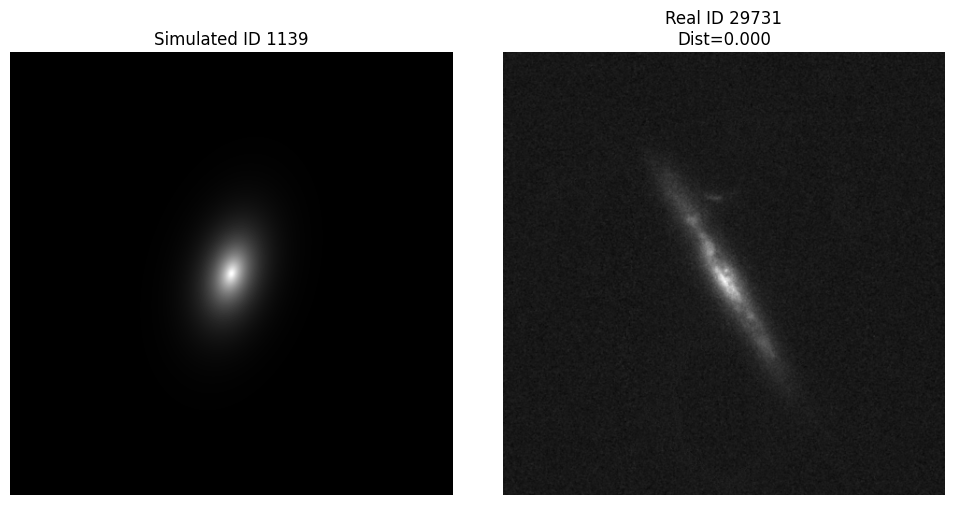

({'lens_light_model_list': ['SERSIC_ELLIPSE'], 'lens_model_list': ['SIE', 'SHEAR', 'CONVERGENCE'], 'source_light_model_list': ['SERSIC_ELLIPSE']}, {'kwargs_lens': [{'theta_E': 0.0, 'e1': -0.0, 'e2': 0.0, 'center_x': 0.007077998739173176, 'center_y': 0.06203557170927644}, {'gamma1': -0.0, 'gamma2': 0.0, 'ra_0': 0, 'dec_0': 0}, {'kappa': 0, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'magnitude': 18.981863091336912, 'R_sersic': 0.9056732326599641, 'n_sersic': 1.0, 'e1': 0.41667305007398525, 'e2': 0.06485900721476404, 'center_x': 0.0, 'center_y': 0.0}], 'kwargs_lens_light': [{'magnitude': 99.0, 'R_sersic': 0.05, 'n_sersic': 1.0, 'e1': -0.0, 'e2': 0.0, 'center_x': 0.007077998739173176, 'center_y': 0.06203557170927644}], 'kwargs_ps': None})


C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lenstronomy\LensModel\lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(


[{'R_sersic': 0.05, 'n_sersic': 1.0, 'e1': -0.0, 'e2': 0.0, 'center_x': 0.007077998739173176, 'center_y': 0.06203557170927644, 'amp': 1.3311310488141806e-28}] [{'R_sersic': 0.9056732326599641, 'n_sersic': 1.0, 'e1': 0.41667305007398525, 'e2': 0.06485900721476404, 'center_x': 0.0, 'center_y': 0.0, 'amp': 41.25461334754549}] None test


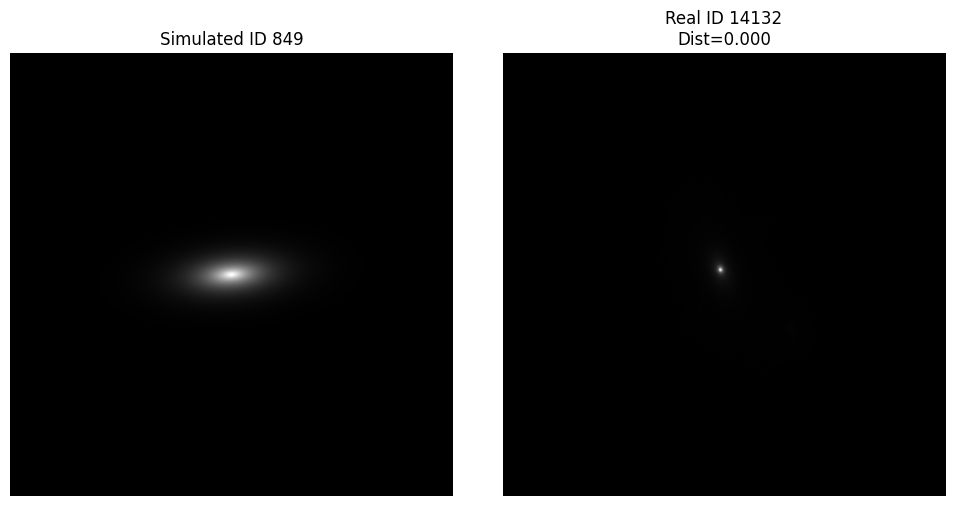

({'lens_light_model_list': ['SERSIC_ELLIPSE'], 'lens_model_list': ['SIE', 'SHEAR', 'CONVERGENCE'], 'source_light_model_list': ['SERSIC_ELLIPSE']}, {'kwargs_lens': [{'theta_E': 0.0, 'e1': -0.0, 'e2': 0.0, 'center_x': 0.001956777079458177, 'center_y': -0.06550042248440674}, {'gamma1': -0.0, 'gamma2': 0.0, 'ra_0': 0, 'dec_0': 0}, {'kappa': 0, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'magnitude': 19.682842892143668, 'R_sersic': 1.0209702120348765, 'n_sersic': 1.0, 'e1': 0.13227075175576675, 'e2': -0.06514494630614988, 'center_x': 0.0, 'center_y': 0.0}], 'kwargs_lens_light': [{'magnitude': 99.0, 'R_sersic': 0.05, 'n_sersic': 1.0, 'e1': -0.0, 'e2': 0.0, 'center_x': 0.001956777079458177, 'center_y': -0.06550042248440674}], 'kwargs_ps': None})
[{'R_sersic': 0.05, 'n_sersic': 1.0, 'e1': -0.0, 'e2': 0.0, 'center_x': 0.001956777079458177, 'center_y': -0.06550042248440674, 'amp': 1.3311310488141806e-28}] [{'R_sersic': 1.0209702120348765, 'n_sersic': 1.0, 'e1': 0.13227075175576675, 'e2': -0.0651

C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lenstronomy\LensModel\lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(


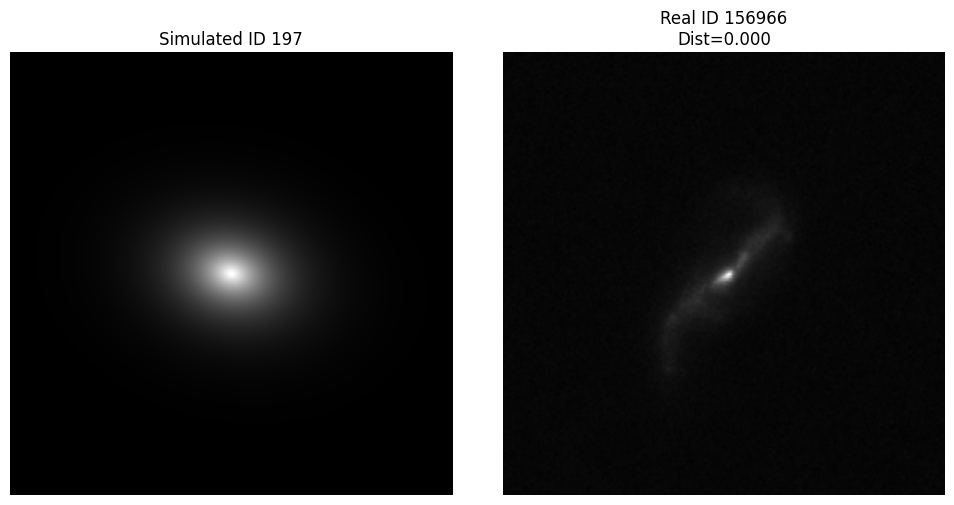

({'lens_light_model_list': ['SERSIC_ELLIPSE'], 'lens_model_list': ['SIE', 'SHEAR', 'CONVERGENCE'], 'source_light_model_list': ['SERSIC_ELLIPSE']}, {'kwargs_lens': [{'theta_E': 0.0, 'e1': -0.0, 'e2': 0.0, 'center_x': -0.05180688120903825, 'center_y': 0.042560346088173225}, {'gamma1': -0.0, 'gamma2': 0.0, 'ra_0': 0, 'dec_0': 0}, {'kappa': 0, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'magnitude': 19.016949031851517, 'R_sersic': 1.5535413044422683, 'n_sersic': 1.0, 'e1': -0.22369408266113294, 'e2': -0.34666770571107175, 'center_x': 0.0, 'center_y': 0.0}], 'kwargs_lens_light': [{'magnitude': 99.0, 'R_sersic': 0.05, 'n_sersic': 1.0, 'e1': -0.0, 'e2': 0.0, 'center_x': -0.05180688120903825, 'center_y': 0.042560346088173225}], 'kwargs_ps': None})


C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lenstronomy\LensModel\lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(


[{'R_sersic': 0.05, 'n_sersic': 1.0, 'e1': -0.0, 'e2': 0.0, 'center_x': -0.05180688120903825, 'center_y': 0.042560346088173225, 'amp': 1.3311310488141806e-28}] [{'R_sersic': 1.5535413044422683, 'n_sersic': 1.0, 'e1': -0.22369408266113294, 'e2': -0.34666770571107175, 'center_x': 0.0, 'center_y': 0.0, 'amp': 13.574867540148185}] None test


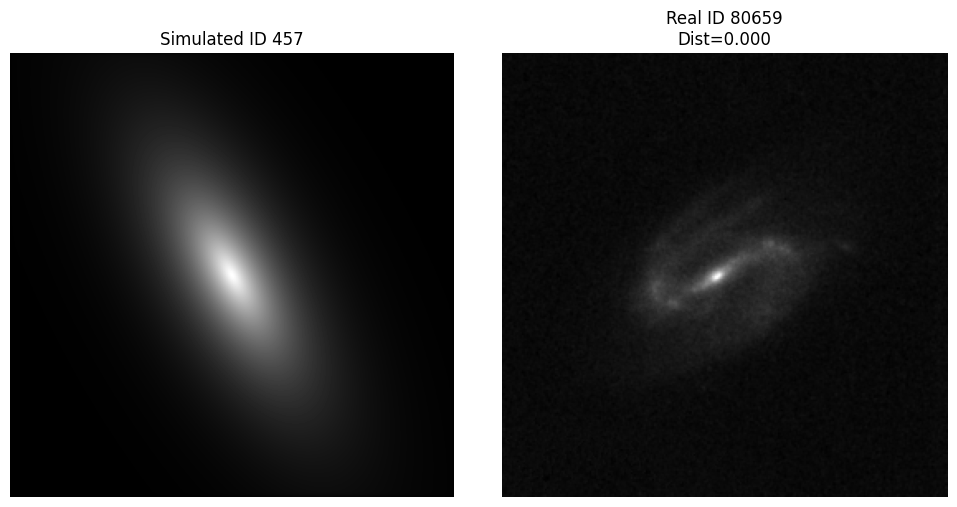

({'lens_light_model_list': ['SERSIC_ELLIPSE'], 'lens_model_list': ['SIE', 'SHEAR', 'CONVERGENCE'], 'source_light_model_list': ['SERSIC_ELLIPSE']}, {'kwargs_lens': [{'theta_E': 0.0, 'e1': -0.0, 'e2': 0.0, 'center_x': 0.006770332555761586, 'center_y': -0.20456327366363736}, {'gamma1': -0.0, 'gamma2': 0.0, 'ra_0': 0, 'dec_0': 0}, {'kappa': 0, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'magnitude': 19.612154076983387, 'R_sersic': 0.6240859415187974, 'n_sersic': 1.0, 'e1': -0.08424669717566172, 'e2': 0.01897941006553407, 'center_x': 0.0, 'center_y': 0.0}], 'kwargs_lens_light': [{'magnitude': 99.0, 'R_sersic': 0.05, 'n_sersic': 1.0, 'e1': -0.0, 'e2': 0.0, 'center_x': 0.006770332555761586, 'center_y': -0.20456327366363736}], 'kwargs_ps': None})


C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lenstronomy\LensModel\lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(


[{'R_sersic': 0.05, 'n_sersic': 1.0, 'e1': -0.0, 'e2': 0.0, 'center_x': 0.006770332555761586, 'center_y': -0.20456327366363736, 'amp': 1.3311310488141806e-28}] [{'R_sersic': 0.6240859415187974, 'n_sersic': 1.0, 'e1': -0.08424669717566172, 'e2': 0.01897941006553407, 'center_x': 0.0, 'center_y': 0.0, 'amp': 48.619489257149624}] None test


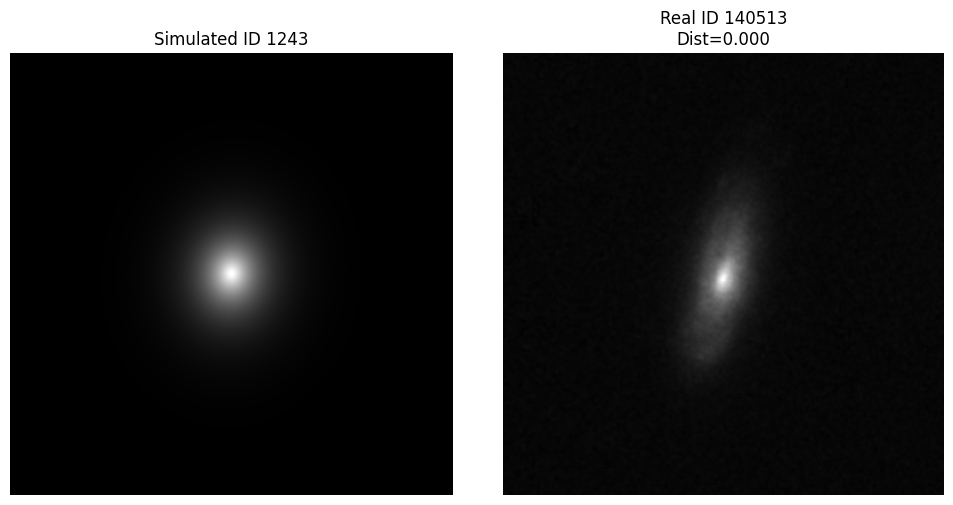

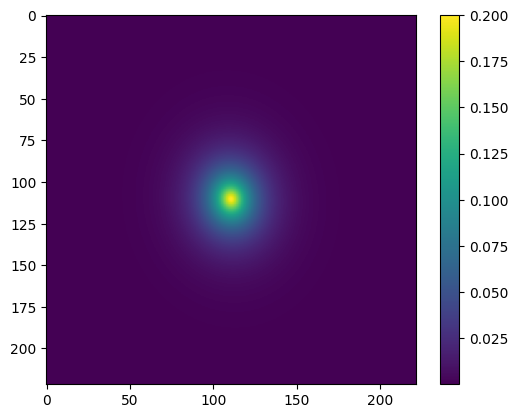

In [22]:
# Cell Y — Plot Top 20 Matches Using SLSIM

from slsim.Sources.source import Source
from slsim.Deflectors.deflector import Deflector
from slsim.LOS.los_individual import LOSIndividual
from slsim.lens import Lens
from slsim.image_simulation import lens_image
from slsim.Util.param_util import gaussian_psf

# Sort the matched table by Distance and take the best 20
top20 = matched[np.argsort(matched['Distance'])][:20]

# directory containing your COSMOS FITS cutouts
real_images_dir = r"C:\Users\rahul\OneDrive\Documents\GitHub\Simulating_and_Predicting_Nancy_G_Roman_Telescope_Data\Datasets\COSMOS_23.5_Image_catalog\COSMOS_23.5_training_sample"

# approximate HST/ACS F814W zero‑point
m_zp = 25.5


# sort & pick top 20
top20 = matched[np.argsort(matched['Distance'])][:5]

for entry in top20:
    # build source dict for SLSIM
    source_dict = {
        "z":            entry["z"],
        "mag_i":        entry["mag_i"],
        "n_sersic":     1,
        "angular_size": entry["angular_size"], # arcseconds
        "e1":           entry["e1"],
        "e2":           entry["e2"],
        "center_x":     0.0,
        "center_y":     0.0,
        "phi_G" : entry["COSMOS_phi_G"],
    }
    source = Source(
        source_dict=source_dict,
        source_type="extended",
        extendedsource_type="single_sersic",
        cosmo=cosmo,
    )

    # dummy, zero‑mass deflector
    deflector = Deflector(
    deflector_type="EPL",
    deflector_dict={
        "z":          entry["z"],     # keep same redshift
        "theta_E":    0.0,            # zero mass
        "e1_light":   0.0,
        "e2_light":   0.0,
        "e1_mass":    0.0,
        "e2_mass":    0.0,
        "gamma_pl":   2.0,
        "angular_size": 0.05,   # [arcsec] any small value
        "n_sersic":    1.0,     # shape index
        "mag_g": 99.0, "mag_r": 99.0, "mag_i": 99.0,
        "mag_z": 99.0, "mag_y": 99.0,
    },
)


    los = LOSIndividual(kappa=0, gamma=[0.0, 0.0])
    lens_class = Lens(
        source_class=source,
        deflector_class=deflector,
        los_class=los,
        cosmo=cosmo,
    )

    print(lens_class.lenstronomy_kwargs(band="i"))

    # load the real COSMOS image
    fname = entry["COSMOS_GAL_FILENAME"]
    hdu   = int(entry["COSMOS_GAL_HDU"])
    path  = os.path.join(real_images_dir, fname)
    with fits.open(path) as hdul:
        real_img = hdul[hdu].data

    # build transform matrix = pixel_scale arcsec/pix
    pixscale = entry["COSMOS_PIXEL_SCALE"]
    transform_pix2angle = np.array([[pixscale, 0], [0, pixscale]])
    psf_kernel = gaussian_psf(fwhm=0.1, delta_pix=entry['COSMOS_PIXEL_SCALE'], num_pix=21)

    # simulate source‑only image
    sim_img = lens_image(
        lens_class=lens_class,
        band="i",
        mag_zero_point=m_zp,
        num_pix=real_img.shape[0],
        psf_kernel=psf_kernel,
        transform_pix2angle=transform_pix2angle,
        exposure_time=None,
        t_obs=None,
        std_gaussian_noise=None,
        with_source=True,
        with_deflector=False,
    )

    # side‑by‑side plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(sim_img, origin="lower", cmap="gray")
    ax1.set_title(f"Simulated ID {entry['IDENT']}")
    ax1.axis("off")
    ax2.imshow(real_img, origin="lower", cmap="gray")
    ax2.set_title(f"Real ID {entry['COSMOS_ID']}\nDist={entry['Distance']:.3f}")
    ax2.axis("off")
    plt.tight_layout()
    plt.show()


plt.imshow(sim_img)
plt.colorbar()
plt.show()

In [ ]:
source_dict = {
        "z":            sim_table["z"][3],
        "mag_i":        sim_table["mag_i"],
        "n_sersic":     entry["n_sersic"],
        "angular_size": entry["R_sersic"],
        "e1":           entry["e1"],
        "e2":           entry["e2"],
        "center_x":     0.0,
        "center_y":     0.0,
    }
    source = Source(
        source_dict=source_dict,
        source_type="extended",
        extendedsource_type="single_sersic",
        cosmo=cosmo,
    )

    # dummy, zero‑mass deflector
    deflector = Deflector(
    deflector_type="EPL",
    deflector_dict={
        "z":          entry["z"],     # keep same redshift
        "theta_E":    0.0,            # zero mass
        "e1_light":   0.0,
        "e2_light":   0.0,
        "e1_mass":    0.0,
        "e2_mass":    0.0,
        "gamma_pl":   2.0,
        "angular_size": 0.05,   # [arcsec] any small value
        "n_sersic":    1.0,     # shape index
        "mag_g": 99.0, "mag_r": 99.0, "mag_i": 99.0,
        "mag_z": 99.0, "mag_y": 99.0,
    },
)


    los = LOSIndividual(kappa=0, gamma=[0.0, 0.0])
    lens_class = Lens(
        source_class=source,
        deflector_class=deflector,
        los_class=los,
        cosmo=cosmo,
    )

    # load the real COSMOS image
    fname = entry["COSMOS_GAL_FILENAME"]
    hdu   = int(entry["COSMOS_GAL_HDU"])
    path  = os.path.join(real_images_dir, fname)
    with fits.open(path) as hdul:
        real_img = hdul[hdu].data

    # build transform matrix = pixel_scale arcsec/pix
    pixscale = entry["COSMOS_PIXEL_SCALE"]
    transform_pix2angle = np.array([[pixscale, 0], [0, pixscale]])
    psf_kernel = gaussian_psf(fwhm=0.1, delta_pix=entry['COSMOS_PIXEL_SCALE'], num_pix=21)

    # simulate source‑only image
    sim_img = lens_image(
        lens_class=lens_class,
        band="i",
        mag_zero_point=m_zp,
        num_pix=real_img.shape[0],
        psf_kernel=psf_kernel,
        transform_pix2angle=transform_pix2angle,
        exposure_time=None,
        t_obs=None,
        std_gaussian_noise=None,
        with_source=True,
        with_deflector=False,
    )

    # side‑by‑side plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(sim_img, origin="lower", cmap="gray_r")
    ax1.set_title(f"Simulated ID {entry['IDENT']}")
    ax1.axis("off")
    ax2.imshow(real_img, origin="lower", cmap="gray")
    ax2.set_title(f"Real ID {entry['COSMOS_ID']}\nDist={entry['Distance']:.3f}")
    ax2.axis("off")
    plt.tight_layout()
    plt.show()